In [1]:
import glacierml as gl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit




2023-08-31 07:20:34.562890: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 07:20:34.607523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 07:20:35.281473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [86]:
def make_frames(parameterization):
    parameterization = '4'
    rootdir = 'temp/'
    losses = ['mae','mse']
    for k in range(1,4,1):
        k = str(k)
        stats1 = pd.DataFrame()
        stats2 = pd.DataFrame()
        for loss in losses:
            stats = pd.read_pickle(
                rootdir + 'model_statistics_xval_' + k + '_' + 
                loss + '_' + parameterization + '.pkl'
            )
            if loss == 'mae':
                stats1 = pd.concat([stats1,stats])
            if loss == 'mse':
                stats2 = pd.concat([stats2,stats])
        stats1['parameter ratio'] = stats1['parameters'] / stats1['inputs']
        stats2['parameter ratio'] = stats2['parameters'] / stats2['inputs']
        stats = pd.merge(
            stats1,stats2,how = 'inner',
            on = ['layer architecture','parameter ratio','parameters',]
        )

        stats = stats.sort_values('parameter ratio')

        fig, ax = plt.subplots()
        x1 = stats['parameter ratio']
        y1 = stats['loss avg_x']
        ax.scatter(
        x1,y1,
        alpha = 0.5,
            label = 'MAE'
        )


        model1 = np.poly1d(np.polyfit(x1, y1, 2))
        ax.plot(x1, model1(x1), alpha = 0.5)

    #     ax.set_xticks(ticks = x_ticks, labels = x_ticks)
        ax2 = ax.twinx()
        x2 = stats['parameter ratio']
        y2 = np.sqrt(stats['loss avg_y'])
        ax2.scatter(
        x2,y2,
        color = 'r',
        alpha = 0.5,
            label = 'MSE'
        )

        model2 = np.poly1d(np.polyfit(x2, y2, 2))
        ax2.plot(x2, model2(x2), alpha = 0.5,c = 'r')

        sts = stats[
            (stats['loss avg_x'] <= model1(x1)) &
#             (stats['loss avg_x'] <= model2(x2)) &
            (np.sqrt(stats['loss avg_y']) <= model2(x2)) 
#             (np.sqrt(stats['loss avg_y']) <= model1(x1))
        ]
    #     print(sts)


        std = stats.drop(sts.index)
#         print(std)
        ax.scatter(
            std['parameter ratio'],
            (std['loss avg_x']),
            color = 'k',
            marker = 'x',
            s = 100
        )
        ax2.scatter(
            std['parameter ratio'],
            np.sqrt(std['loss avg_y']),
            color = 'k',
            marker = 'x',
            s = 100
        )
        ax.scatter(
            sts['parameter ratio'],
            (sts['loss avg_x']),
            color = 'orange', marker = '.'
        )
        ax2.scatter(
            sts['parameter ratio'],
            np.sqrt(sts['loss avg_y']),
            color = 'orange', marker = '.'
        )



    #     popt, pcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(4, 0.1))
    #     plt.plot(x, popt[0]*np.exp(popt[1]*x),c = 'red', alpha = 0.5) #same as line above \/

        fig.patch.set_facecolor('w')
        ax.grid(False)
        ax2.grid(False)
        ax.set_xlabel('Trained Parameters / Inputs')
        ax.set_ylabel('Mean Absolute Error (m)')
        ax2.set_ylabel(r'$\mathrm{\sqrt{Mean Squared Error (m^2)}}$')
        plt.title('Fold K* = ' + k)
    #     plt.title('Model Comparison of MAE vs MSE\nParameterization ' + parameterization)
    #     plt.legend()
        plt.show()



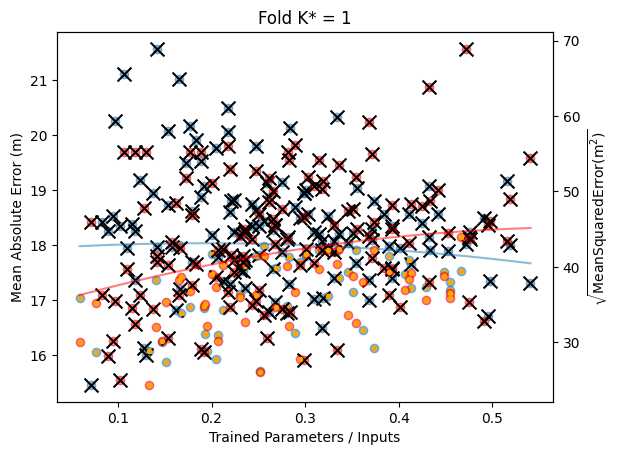

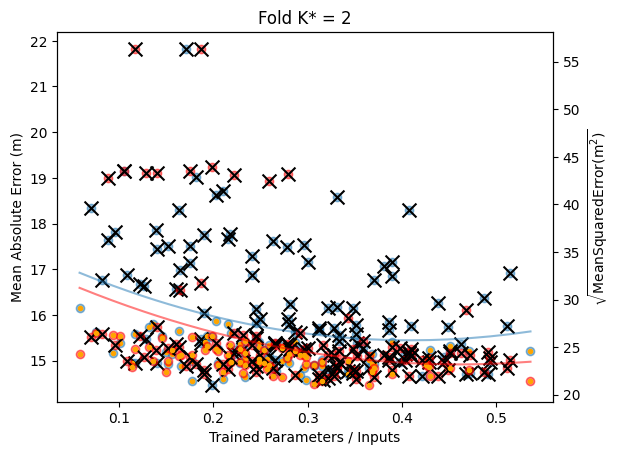

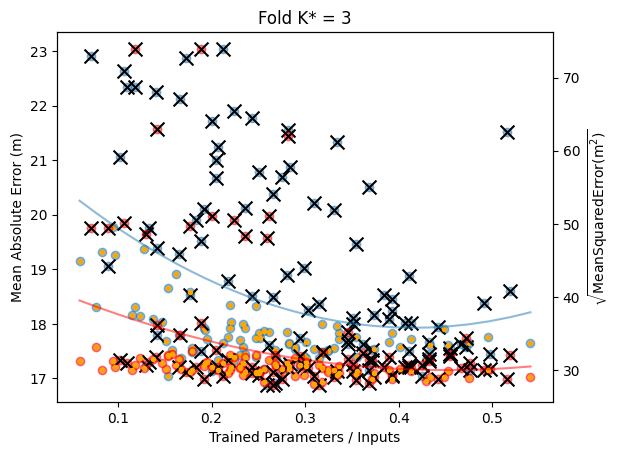

In [87]:
# for j in range(1,5,1):
make_frames(str(4))

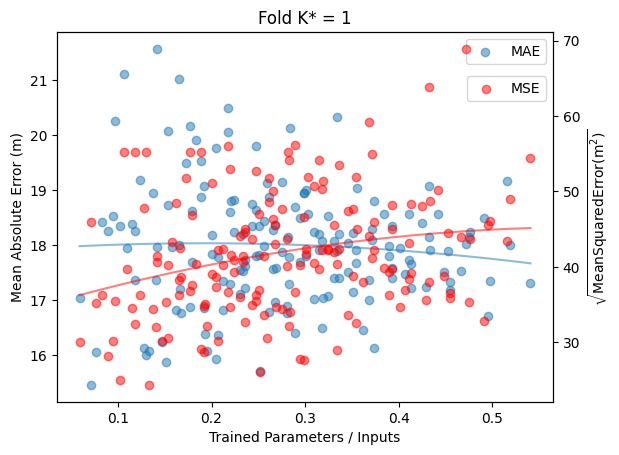

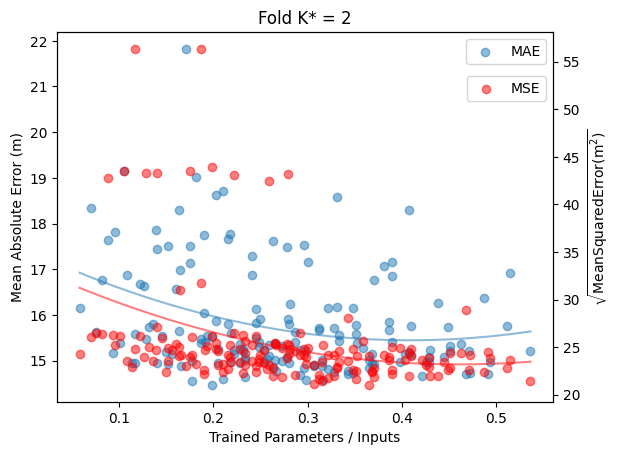

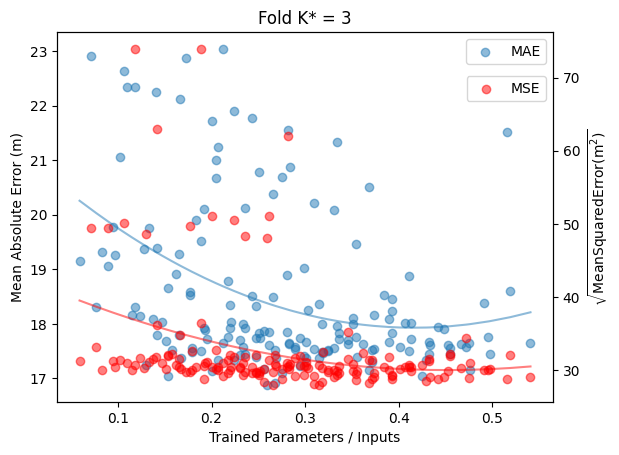

In [194]:
parameterization = '4'
rootdir = 'temp/'
losses = ['mae','mse']
stats1 = pd.DataFrame()
stats2 = pd.DataFrame()
for k in range(1,4,1):
    k = str(k)

    for loss in losses:
        stats = pd.read_pickle(
            rootdir + 'model_statistics_xval_' + k + '_' + 
            loss + '_' + parameterization + '.pkl'
        )
        stats['fold'] = k
        if loss == 'mae':
            stats1 = pd.concat([stats1,stats])
        if loss == 'mse':
            stats2 = pd.concat([stats2,stats])
stats1['parameter ratio'] = stats1['parameters'] / stats1['inputs']
stats2['parameter ratio'] = stats2['parameters'] / stats2['inputs']
stats = pd.merge(
    stats1,stats2,how = 'inner',
    on = ['layer architecture','parameter ratio','parameters','fold']
)
stats = stats.sort_values('parameter ratio')

k1 = stats[stats['fold'] == '1']
k2 = stats[stats['fold'] == '2']
k3 = stats[stats['fold'] == '3']
k_list = [k1,k2,k3]
n_list = ['1','2','3']

arch_list = pd.DataFrame()

for n, k in zip(n_list, k_list):
    

    x1 = k['parameter ratio']
    y1 = k['loss avg_x']
    model1 = np.poly1d(np.polyfit(x1, y1, 2))

    x2 = k['parameter ratio']
    y2 = np.sqrt(k['loss avg_y'])
    model2 = np.poly1d(np.polyfit(x2, y2, 2))
    
    sts = k[
        (k['loss avg_x'] <= model1(x1)) &
#         (k['loss avg_x'] <= model2(x2)) &
        (np.sqrt(k['loss avg_y']) <= model2(x2)) 
#         (np.sqrt(k['loss avg_y']) <= model1(x1))
    ]
    std = k.drop(sts.index)
    
    if n == '1':
        arch_list_1 = sts
    if n == '2':
        arch_list_2 = sts     
    if n == '3':
        arch_list_3 = sts
    
    fig, ax = plt.subplots()
    ax.scatter(
    x1,y1,
    alpha = 0.5,
    label = 'MAE'
    )
    model1 = np.poly1d(np.polyfit(x1, y1, 2))
    ax.plot(x1, model1(x1), alpha = 0.5)

#     #     ax.set_xticks(ticks = x_ticks, labels = x_ticks)
    ax2 = ax.twinx()
    ax2.scatter(
    x2,y2,
    color = 'r',
    alpha = 0.5,
    label = 'MSE'
    )

    # model2 = np.poly1d(np.polyfit(x2, y2, 2))
    ax2.plot(x2, model2(x2), alpha = 0.5,c = 'r')
#     ax2.set_ylabel('')

    
# #     print(std)
#     ax.scatter(
#         std['parameter ratio'],
#         (std['loss avg_x']),
#         color = 'k',
#         marker = 'x',
#         s = 100
#     )
#     ax2.scatter(
#         std['parameter ratio'],
#         np.sqrt(std['loss avg_y']),
#         color = 'k',
#         marker = 'x',
#         s = 100
#     )
#     ax.scatter(
#         sts['parameter ratio'],
#         (sts['loss avg_x']),
#         color = 'orange', marker = '.'
#     )
#     ax2.scatter(
#         sts['parameter ratio'],
#         np.sqrt(sts['loss avg_y']),
#         color = 'orange', marker = '.'
#     )
    
#     arch_list = pd.concat([arch_list, sts])
    
    fig.patch.set_facecolor('w')
    ax.grid(False)
    ax2.grid(False)
    ax.set_xlabel('Trained Parameters / Inputs')
    ax.set_ylabel('Mean Absolute Error (m)')
    ax2.set_ylabel(r'$\mathrm{\sqrt{Mean Squared Error (m^2)}}$')
    plt.title('Fold K* = ' + n)    
    ax.legend(loc = 'upper right')
    ax2.legend(loc = 'upper right',bbox_to_anchor=(0.5, 0.1, 0.5, 0.8))

In [190]:
arch_list = pd.merge(
    arch_list_1['layer architecture'], 
    arch_list_2['layer architecture'],
    how = 'inner', on = 'layer architecture'
)
arch_list = pd.merge(
    arch_list, 
    arch_list_2['layer architecture'],
    how = 'inner', on = 'layer architecture'
)
arch_list = arch_list.sort_values('layer architecture')

In [191]:
arch_list

,layer architecture
5,10-4
9,10-7
14,11-10
10,11-6
12,11-8
7,12-4
11,12-5
18,14-12
13,14-5
17,16-7


In [176]:
arch_list = arch_list.groupby('fold').filter(lambda x: len(x) > 3)
# arch_list = arch_list.drop_duplicates(keep = 'first')

In [175]:
# arch_list[arch_list['layer architecture'] == '3-2']

array(['3-2', '4-3', '7-5', '9-3', '8-5', '9-4', '10-4', '8-7', '10-5',
       '13-3', '12-4', '9-8', '10-7', '11-6', '12-5', '16-2', '11-8',
       '14-5', '12-8', '14-6', '11-10', '19-3', '17-5', '14-8', '19-4',
       '13-10', '16-7', '14-10', '20-5', '18-7', '16-9', '14-12', '19-7',
       '16-10', '14-13', '18-9', '20-8', '16-13', '20-9', '19-10',
       '17-13', '17-14', '20-11', '19-12', '17-15', '6-2', '6-3', '7-3',
       '6-5', '8-4', '11-2', '8-6', '11-4', '12-3', '13-4', '10-8',
       '15-3', '12-6', '13-5', '16-3', '15-4', '13-6', '18-2', '13-7',
       '15-5', '18-3', '20-2', '12-9', '16-5', '12-10', '18-4', '16-6',
       '18-5', '17-6', '15-8', '19-5', '13-11', '15-9', '17-7', '20-7',
       '19-8', '16-11', '17-11', '20-10', '19-11', '19-13', '20-15',
       '5-2', '5-4', '7-4', '8-3', '10-3', '9-5', '11-5', '14-4', '10-9',
       '12-7', '16-4', '19-2', '15-6', '12-11', '13-12', '19-6', '17-8',
       '18-8', '17-9', '16-12', '15-14', '18-11', '18-13', '19-14'],
    

In [178]:
len(arch_list['layer architecture'].unique())

111

In [124]:
sts = stats[
    (stats['loss avg_x'] <= model1(x1)) &
#     (stats['loss avg_x'] <= model2(x1)) &
    (np.log(stats['loss avg_y']) <= model2(x2)) 
#     (np.log(stats['loss avg_y']) <= model1(x1))
]

std = stats.drop(sts.index)
std1 = std[std['fold'] == '1']
std2 = std[std['fold'] == '2']
std3 = std[std['fold'] == '3']

df1 = pd.merge(
    std2['layer architecture'],
    std1['layer architecture'],
    how='inner',on = 'layer architecture'           
)
arch = pd.merge(
    test_1['layer architecture'],
    std3['layer architecture'],
    how='inner',on = 'layer architecture'           
)
arch

ValueError: ('Lengths must match to compare', (483,), (161,))